# Evaluate BART on NIST vs on NEIMS

a) projet 8M BARTA na testovaci sade NEIMSu, ktera nebyla pouzita pri treninku niceho
 	=> porovnat predikce na NISTU a NEIMSu (sleduj miru BIASu NEIMSu)
    
 	   - pokud vyjde srovnatelne dobre, u obou, NIST dela dobrou praci pri aproximaci a
 	 	problem je v RCX zaspineni
 	   - pokud vyjde spatne, NEIMS vytvari vlastni druh spekter, odlisny od jakekilv reality a 
	 	 jedem GARBAGE in, GARBAGE out
b) porovnej vykon standardniho 8M Barta na deriv vs. nonderiv <br>
c) porovnej vykon DERIV Barta na deriv vs. nonderiv<br>

________________________________________________________________________
### WARPLAN
- ulozit NIST20-only datafram/y a projet pipelinou na pripravu dat (s NEIMSem jako inputem)
- z pole spekter vykres preprocesovany datasety (s NISTem jako inputem)
- oevaluj a porovnej - 

In [ ]:
# copied imports, maybe filter later
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from matchms.importing import load_from_msp
from spectra_process_utils import preprocess_spectra, preprocess_spectrum
from geneval_utils import evaluate_range_opt2_prob

import sys
from dataset import SpectroDataset, SpectroDataCollator
sys.path.append('data')
sys.path.append('bart_spektro')
from modeling_bart_spektro import BartSpektoForConditionalGeneration
from configuration_bart_spektro import BartSpektroConfig
from tokenizers import Tokenizer

In [ ]:
# hide rdkit warnings
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*') 

## Load NIST20only/NEIMS csv

In [ ]:
# load NIST20only/NEIMS csv
df_nist20only = pd.read_csv("./data/NIST/NIST_20only/df_all.csv")

# add the spektra from .msp files

In [ ]:
df_nist20only

## Turn list of spectra into dataset
needed columns: destereo_smiles, input_ids, position_ids

In [ ]:
tok = "./tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
tokenizer = Tokenizer.from_file(tok)

In [ ]:
# load spectra from .msp file
nist20only_nist_spectra = load_from_msp("data/NIST/NIST_20only/NIST20_only_NIST.msp", metadata_harmonization=False)
nist20only_neims_spectra = load_from_msp("data/NIST/NIST_20only/NIST20_only_NEIMS.msp", metadata_harmonization=False)

In [ ]:
nist20only_nist_spectra

In [ ]:
# preprocess spectra -> df that can be fed into a SpectroDataset
print("NIST")
df_nist20only_nist = preprocess_spectra(nist20only_nist_spectra, tokenizer, spectra_name="NIST_spectra")
print("##########################\nNEIMS")
df_nist20only_neims = preprocess_spectra(nist20only_neims_spectra, tokenizer, spectra_name="NEIMS_spectra")

In [ ]:
# create SpectroDataset
nist_data = SpectroDataset(df_nist20only_nist, original=False, eval_mode=True)
neims_data = SpectroDataset(df_nist20only_neims, original=False, eval_mode=True)

In [ ]:
nist_data.data

## Load model and tokenizer 

In [ ]:
# init model
global model_path
# model_path = f'./models/bart_2022-10-14-16_15_31_ft_12M_derivatized/checkpoint-58536/'
model_path = f'./models/bart_2022-10-14-16_15_31_ft_12M_derivatized/checkpoint-58536/'
model_name = ''.join(model_path.split('/')[-3])
model = BartSpektoForConditionalGeneration.from_pretrained(model_path)

# put model into eval mode and on device
model.eval()
device = 'cuda' # 'cpu' alternatively
model.to(device)

# change some configs
model.config.eos_token_id = 0
model.config.bos_token_id = 3
model.config.pad_token_id = 2
model.config.decoder_start_token_id = 3
model.config.forced_eos_token_id = 0
model.config.max_length = 200
model.config.min_length = 0

## Synchronize NIST and NEIMS
Synchronize the two dataset so it contains the same datapoints in the same order (even after filtering)
- get nist and neims ids
- get all original ids
- create throw_out_of_nist ((all_ids - neims_ids) - (all_ids - nist_ids)) and throw_out_of_neims (analogically)

In [ ]:
%%time
nist_data_ids = [int(row[1].NIST_spectra.metadata["id"]) for row in nist_data.data.iterrows()]
neims_data_ids = [int(row[1].NEIMS_spectra.metadata["id"]) for row in neims_data.data.iterrows()]
all_nist20only_ids = df_nist20only.nist_id.astype(int)

In [ ]:
# add nist_id column
nist_data.data["nist_ids"] = nist_data.data.NIST_spectra.apply(lambda x: int(x.metadata["id"]))
neims_data.data["nist_ids"] = neims_data.data.NEIMS_spectra.apply(lambda x: int(x.metadata["id"]))

In [ ]:
# filter out "throw_out..." ids
df_nist_data_sync = nist_data.data[nist_data.data.nist_ids.isin(neims_data_ids)]
df_neims_data_sync = neims_data.data[neims_data.data.nist_ids.isin(nist_data_ids)]

nist_data_sync = SpectroDataset(df_nist_data_sync, eval_mode=True)
neims_data_sync = SpectroDataset(df_neims_data_sync, eval_mode=True)

# Evaluate

  0%|          | 0/5000 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 5000/5000 [36:06<00:00,  2.31it/s]
/auto/brno2/home/ahajek/Spektro/MassGenie/geneval_utils.py:355: RuntimeWarning: invalid value encountered in double_scalars
  rmse = np.sqrt(np.sum((is_sorted_by_gt_indexes - gt_sorted_by_gt_indexes)**2)/len(is_sorted_by_gt_indexes))


###### RESULTS ######
model: bart_2022-10-14-16_15_31_ft_12M_derivatized
additional info: _nist20only_nist_ATT
data range: (35000, 39999)
generated for each example: 10 samples
data type: nist_data_sync
mean RMSE of prob_simil ranking compared to GT: nan
recall@1: 0.1616
recall@3: 0.4216
average smiles simil from all unique samples: 0.3353781565244699
average simles simil from the 3 best samples: 0.4086881154581606
average smiles simil from the 1 best sample: 0.44745010545028724
mean num of unique vals: 8.5154



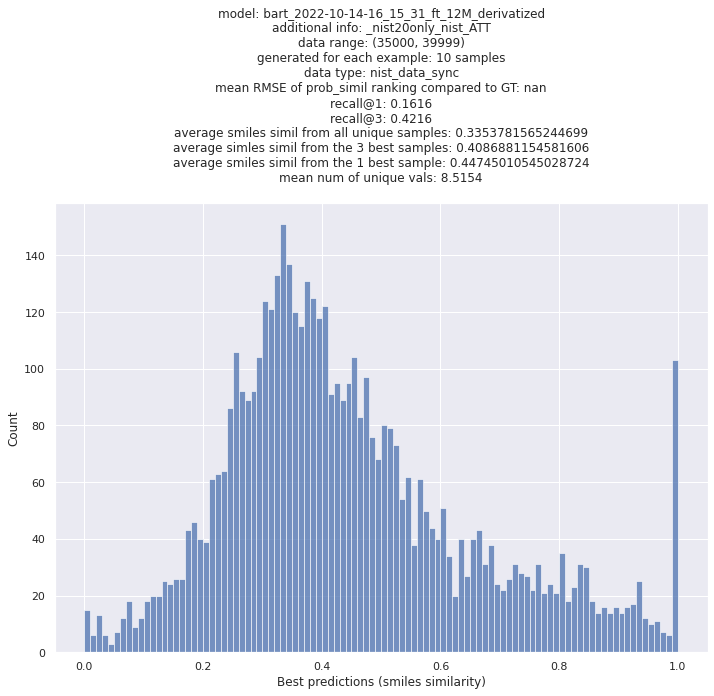

[0.12788018433179724,
 0.5277161862527716,
 0.18131359851988899,
 0.5381062355658198,
 0.43759873617693523,
 0.4354183590576767,
 0.5325914149443561,
 0.27323943661971833,
 0.4,
 0.8414634146341463,
 0.6495327102803738,
 0.5,
 0.3076923076923077,
 0.6,
 0.8538812785388128,
 0.3076923076923077,
 0.5796178343949044,
 0.6725352112676056,
 0.9387755102040817,
 0.5751445086705202,
 0.7267441860465116,
 0.5673469387755102,
 0.7650273224043715,
 0.7540983606557377,
 0.5785340314136126,
 0.6650717703349283,
 0.6510416666666666,
 0.5757575757575758,
 0.6051502145922747,
 0.7123893805309734,
 0.8373702422145328,
 0.7391304347826086,
 0.8518518518518519,
 0.7239583333333334,
 0.46540880503144655,
 0.47058823529411764,
 0.584070796460177,
 0.9626556016597511,
 0.34065934065934067,
 0.3054054054054054,
 0.3469387755102041,
 0.14705882352941177,
 0.4201457919151756,
 0.38341158059467917,
 0.5756207674943566,
 0.41961414790996787,
 0.5759162303664922,
 0.4420401854714065,
 0.45662460567823343,
 0.351

In [69]:
# evaluate NIST
RANGE = range(35000,40000)
additional_info = "_nist20only_nist_ATT"
evaluate_range_opt2_prob(model, 
                         model_name, 
                         tokenizer, 
                         nist_data_sync,
                         data_type="nist_data_sync",
                         data_range=RANGE, 
                         additional_info=additional_info, 
                         gt_list=list(df_nist_data_sync["smiles"])[min(RANGE):max(RANGE)+1], 
                         num_generated=10)

  0%|          | 0/30 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 30/30 [00:06<00:00,  4.29it/s]


###### RESULTS ######
model: bart_2022-10-14-16_15_31_ft_12M_derivatized
additional info: _nist20only_neims_ATT
data range: (0, 29)
generated for each example: 10 samples
data type: neims_data_sync
mean RMSE of prob_simil ranking compared to GT: 1.9982725342682663
recall@1: 0.3
recall@3: 0.6666666666666666
average smiles simil from all unique samples: 0.47175799406124586
average simles simil from the 3 best samples: 0.5527385268530471
average smiles simil from the 1 best sample: 0.5846025675095968
mean num of unique vals: 5.733333333333333



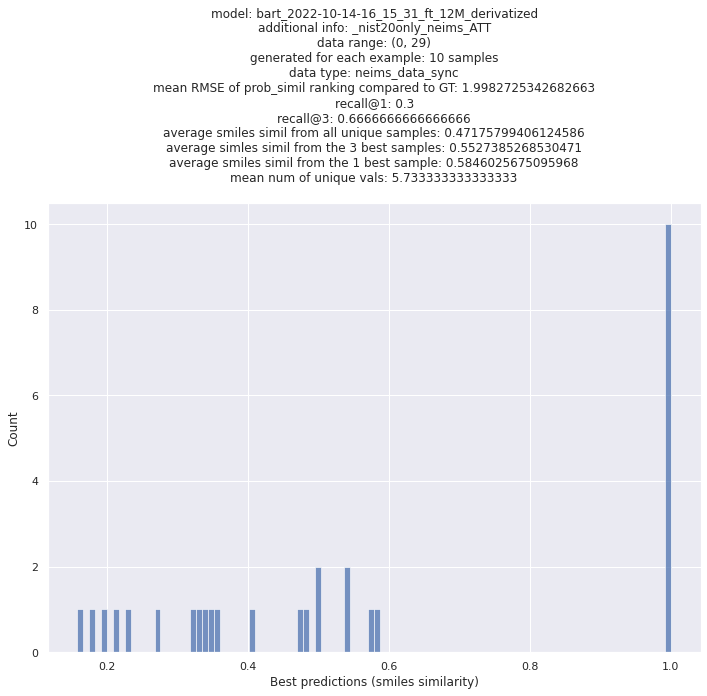

[1.0,
 0.3235685752330226,
 0.2677966101694915,
 0.4098101265822785,
 0.1932059447983015,
 0.15789473684210525,
 0.35930047694753575,
 0.17751479289940827,
 0.23255813953488372,
 0.21338912133891214,
 0.5796847635726795,
 0.542649727767695,
 0.5760869565217391,
 0.5025728987993139,
 0.49950445986124875,
 0.4708680142687277,
 0.3370307167235495,
 1.0,
 0.48106904231625836,
 1.0,
 1.0,
 1.0,
 0.3456521739130435,
 0.33035714285714285,
 0.5375626043405676,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [65]:
# evaluate NEIMS
RANGE = range(0,30)
additional_info = "_nist20only_neims_ATT"
evaluate_range_opt2_prob(model, 
                         model_name, 
                         tokenizer, 
                         neims_data_sync,
                         data_type="neims_data_sync",
                         data_range=RANGE, 
                         additional_info=additional_info, 
                         gt_list=list(df_neims_data_sync["smiles"])[min(RANGE):max(RANGE)+1], 
                         num_generated=10)

In [ ]:
neims_data_sync[13000]

## Visualize a single prediction

/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1359: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


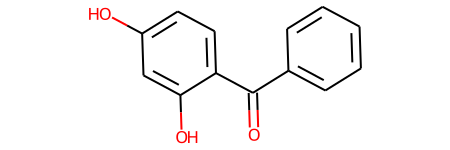

Ground Truth SMILES: O=C(c1ccccc1)c1ccc(O)cc1O


,index,smiles,ROMol,SMILES_simil
0,7,O=C(c1ccccc1)c1ccc(O)cc1O,,1.000000
1,0,O=C(c1ccccc1)c1ccc(O)c(O)c1,,0.613889
2,8,O=C(c1ccccc1)c1ccc(O)c(O)c1,,0.613889
3,9,O=C(c1ccccc1)c1ccc(O)c(O)c1,,0.613889
4,3,O=C(C=Cc1ccco1)c1ccccc1,,0.157895
5,6,O=C(C=Cc1ccco1)c1ccccc1,,0.157895
6,1,Oc1ccc(N=Nc2ccccc2)cc1O,,0.147321
7,2,Oc1ccc(N=Nc2ccccc2)cc1O,,0.147321
8,4,Oc1ccc(N=Nc2ccccc2)cc1O,,0.147321
9,5,Oc1ccc(N=Nc2ccccc2)cc1O,,0.147321

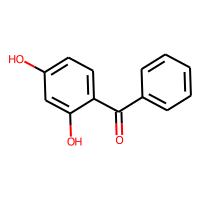
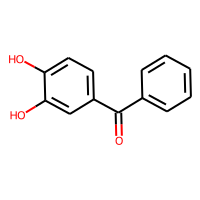
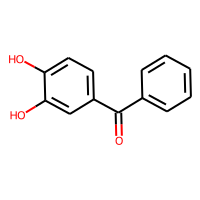
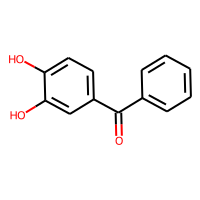
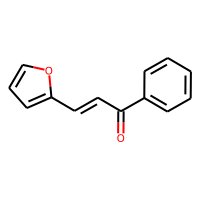
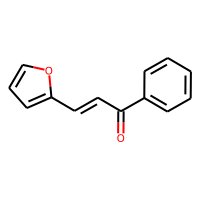
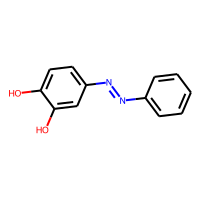
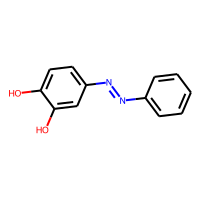
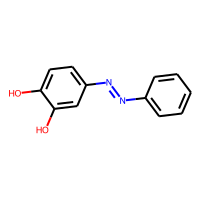
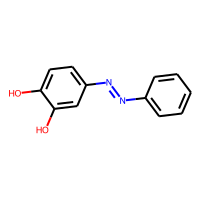

In [64]:
data_id=349
data=neims_data_sync
show_predictions_for_datapoint(model, tokenizer, nist_data[data_id], gt_smiles=data.data.iloc[data_id].smiles, num_generated=10)

In [57]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List
from numbers import Number
from rdkit import Chem, DataStructs
from tokenizers import Tokenizer
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from geneval_utils import rmse_simils_unique

def evaluate_range_opt2_prob(model, model_name, tokenizer, data, data_type, data_range, additional_info="", figure_save_dir="figures",  printing=True,  gt_list=[], num_generated=100, penalty_alpha=None, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, device="cuda"):
    """
    Evaluates model on a given range of given dataset. For every datapoint it sorts 
    generated SMILES according to the probability of each SMILES to be generated. 
    The quality of the sorting is expressed by RMSE with the ground truth sorting.
    
    The outputed graph (saved at particular location) contains several statistics.
    
    Parameters
    ----------
    model : BartSpektoForConditionalGeneration
        model to be evaluated
    model_name : str
        name used as an identifier of given model in titles and figure file name
    tokeznizer : tokenizers.Tokenizer
        tokenizer to use for decoding the ground truth smiles
    data : SpectroDataset
        dataset from which we take a slice according to data_range
    data_type : str
        name used as an identifier of given dataset in titles and figure file name
    data_range : range
    additional_info : stringgure (gets to file name and figure title)
        additional info to the fi
    figure_save_dir : str
        directory to use for saving stat figure
    printing : bool
        whether or not print the final statistics 
    gt_list : List[str]
        a parameter to help eval_mode - a list of ground truth SMILES for a reference
    num_generated : int
        number of generated SMILES for each datapoint
    penalty_alpha : float
        parametr of Hugging face generate function, if penalty_alpha>0 and top_k>1 => CONTRASTIVE SEARCH is used
    top_k : int
        parametr of Hugging face generate function
    top_p : float
        parametr of Hugging face generate function
    do_sample : bool
        parametr of Hugging face generate function
    num_beams : int
        parametr of Hugging face generate function
    temperature : float
        parametr of Hugging face generate function
    device : str
        cuda or cpu
    
    Returns
    -------
    histplot : matplotlib.figure.Figure
        statistics about the evaluation, the histogram shows counts of best generated spectra with particular similarities
    """
    all_datapoint_ids = []
    all_smiles = []
    all_sequence_probs = []
    min_range = min(data_range)
    gt_smiless = []  
    
    
    for id_ in tqdm(data_range):
        inputs = data[id_]
        if gt_list:
            gt_smiles = gt_list[id_ - min_range]
        else:
            gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
        
        gt_smiless.append(gt_smiles)
        generated_smiless = []

        # generate
        input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
        generated_outputs = model.generate(
                               input_ids=input_ids,
                               num_return_sequences = num_generated,
                               position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                               attention_mask=inputs["attention_mask"].unsqueeze(0).to(device=device),
                               top_k=top_k,
                               penalty_alpha=penalty_alpha,
                               top_p=top_p,
            #                    min_length=20,
            #                    max_length=200,
                               do_sample=do_sample,
                               num_beams=num_beams,
                               temperature=temperature,
                               return_dict_in_generate=True,
                               output_scores=True)

        # decode the generated SMILESs
        generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]
        generated_smiless_enum = list(enumerate(generated_smiless)) # enum for analizing which smiles drops after validation
        
        # filter invalid
        valid_smiless = [s for s in generated_smiless_enum if Chem.MolFromSmiles(s[1])]
        valid_idxs = [s[0] for s in valid_smiless]
        
        # canonize
        canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi[1]),True) for smi in valid_smiless]
    
        ### PROBS computig
        # let's stack the logits generated at each step to a tensor and transform logits to probs
        raw_probs = torch.stack(generated_outputs.scores, dim=1).softmax(-1)  # -> shape [3, 15, vocab_size]

        # collect the probability of the generated token
        token_probs = torch.gather(raw_probs, 2, generated_outputs.sequences[:, 1:, None]).squeeze(-1)
        
        # filter out invalid smiles
        valid_token_probs = torch.index_select(token_probs, 0, torch.tensor(valid_idxs, dtype=torch.int64).to(device))

        # normalize the probs ?or not?
#         valid_token_probs = valid_token_probs / valid_token_probs.sum(0)
#         assert valid_token_probs[:, 0].sum() == 1.0, "probs should be normalized"
        
        # multiply all the probs in each sequence except for the zero values
        valid_token_probs[valid_token_probs==0] = 1 # replace zeros for neutral element -> 1

        sequence_probs = valid_token_probs.prod(dim=1).tolist()
        
        all_smiles += canon_smiles
        all_datapoint_ids += [id_]*len(canon_smiles)
        all_sequence_probs += sequence_probs
    
    df_all_data = pd.DataFrame({"datapoint_ID":all_datapoint_ids, 
                                "smiles": all_smiles,
                                "smiles_prob": all_sequence_probs})   
    
    rmses = []
    topNSmi = []
    top1sumSmi = 0
    top3sumSmi = 0
    all_top1Smi = []
    
    diff_unique_vals = 0 # check how many pairs of simil arrays have different num of unique vals
    success1 = 0
    success3 = 0
    unique_vals = 0
    unable_to_generate_anything = []
    
    
    for id_ in data_range:
        inputs = data[id_]
        gt_smiles = gt_smiless[id_ - min_range]
        df_id_subset = df_all_data[df_all_data['datapoint_ID'] == id_].copy()

        
        # compute SMILES simil
        ms = [Chem.MolFromSmiles(smiles) for smiles in df_id_subset["smiles"]]
        gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
        fps = [Chem.RDKFingerprint(x) for x in ms if x]
        smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]            
        
        # get computed probs from df
        smiles_probs = df_id_subset["smiles_prob"]

        # compare the two simil lists (RMSE)
        rmse, (idxs_prob, idxs_GT) = rmse_simils_unique(smiles_probs, smiles_simils)
        rmses.append(rmse)
        
        if idxs_prob.size > 0:
            ### STATS        
            if 0 == idxs_prob[0]:
                success1 += 1 
            if 0 in idxs_prob[:3]:
                success3 += 1
            unique_vals_curr = max(idxs_prob) + 1
            unique_vals += unique_vals_curr

            ###### STATS 2
            smiles_simils.sort(reverse=True)
            topNSmi = np.concatenate((topNSmi, smiles_simils))
            top1sumSmi += smiles_simils[0]
            top3sumSmi += sum(smiles_simils[:3])
            all_top1Smi.append(smiles_simils[0])
        else: 
            unable_to_generate_anything.append(gt_smiles)
        
    ############## OUTPUT ################
    topNaverageSmi = sum(topNSmi)/len(topNSmi)
    top1averageSmi = top1sumSmi/len(data_range)
    top3averageSmi = top3sumSmi/(len(data_range)*3)
    
    num_of_datapoints = max(data_range)-min(data_range)+1
    output_text = \
      f"model: {model_name}\n" + \
      f"additional info: {additional_info}\n" + \
      f"data range: ({min(data_range)}, {max(data_range)})\n"+ \
      f"generated for each example: {num_generated} samples\n"+\
      f"data type: {data_type}\n" +\
      f"mean RMSE of prob_simil ranking compared to GT: {sum(rmses)/len(rmses)}\n" +\
      f"recall@1: {success1/num_of_datapoints}\n"+\
      f"recall@3: {success3/num_of_datapoints}\n"+\
      f"average smiles simil from {'all unique'} samples: {topNaverageSmi}\n"+\
      f"average simles simil from the 3 best samples: {top3averageSmi}\n"+\
      f"average smiles simil from the 1 best sample: {top1averageSmi}\n"+\
      f"mean num of unique vals: {unique_vals/num_of_datapoints}\n"

    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(all_top1Smi, bins=100).set_title(output_text)
    fig = histplot.get_figure()
    plt.xlabel("Best predictions (smiles similarity)")
    fig.savefig(f"{figure_save_dir}/option2_prob{additional_info}_{model_name}_{data_type}_generated{num_generated}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    
        
    if printing:
        print(f"###### RESULTS ######\n" + output_text)
        plt.show()
        
    return all_top1Smi


In [28]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List
from numbers import Number
from rdkit import Chem, DataStructs
from tokenizers import Tokenizer
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from geneval_utils import rmse_simils_unique

# imports show_pred...
from rdkit.Chem import PandasTools

def show_predictions_for_datapoint(model, tokenizer, inputs, num_generated=10, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True, gt_smiles=""):
#     inputs = data[id_]
    if not gt_smiles:
        gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
    
    # generate
    generated_smiless = []          
    input_ids = inputs["input_ids"].unsqueeze(0).to(device=device)
    position_ids=inputs["position_ids"].unsqueeze(0).to(device=device)
    attention_mask=inputs["attention_mask"].unsqueeze(0).to(device=device)

    generated_outputs = model.generate(
                           input_ids=input_ids,
                           num_return_sequences = num_generated,
                           position_ids=position_ids,
                           attention_mask=attention_mask,
                           top_p=top_p,
                           top_k=top_k,
        #                    min_length=20,
        #                    max_length=200,
                           do_sample=do_sample,
                           num_beams=num_beams,
                           temperature=temperature,
                           return_dict_in_generate=True,
                           output_scores=False)

    # decode the generated SMILESs
    generated_smiless = [tokenizer.decode(generated[1:-1]) for generated in generated_outputs.sequences.tolist()]

    # deduplicate (or not)
    unique_smiless = generated_smiless # unique_nonsorted(np.array(generated_smiless)) #####################################
    
    # filter invalid
    valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]
    
    # canonize
    canon_smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi),True) for smi in valid_smiless]
    
    df_valid_smiles = pd.DataFrame(canon_smiles, columns=["smiles"])
    
    Chem.PandasTools.AddMoleculeColumnToFrame(df_valid_smiles, smilesCol='smiles', molCol='ROMol')
    
    df = df_valid_smiles
    
    # compute SMILES simil
    ms = [Chem.MolFromSmiles(smiles) for smiles in df["smiles"]]
    gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
    fps = [Chem.RDKFingerprint(x) for x in ms if x]
    smiles_simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]
    
    df["SMILES_simil"] = smiles_simils
    
    if printing:
#         print("##### GROUND TRUTH #####")
#         print(f"Ground Truth SMILES: {gt_smiles}")
#         print(f"Input mzs: {input_ids}")
#         print(f"Input logbin intensities: {position_ids}")
#         print(f"Input attention mask: {attention_mask}")
        mol = Chem.MolFromSmiles(gt_smiles)
        display(mol)
        print("Ground Truth SMILES:", gt_smiles)
    
    return df.sort_values(by="SMILES_simil", ascending=False).reset_index()

In [ ]:
import torch
torch.cuda.empty_cache()